In [1]:
#!git clone https://github.com/calebchiam/cs6742-fork

Cloning into 'cs6742-fork'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 3653 (delta 101), reused 116 (delta 57), pack-reused 3481
Receiving objects: 100% (3653/3653), 39.07 MiB | 1.03 MiB/s, done.
Resolving deltas: 100% (2369/2369), done.


In [1]:
from tqdm import tqdm
import os
os.chdir('/Users/grace/cs6742-fork/')
from convokit import Corpus, User, Utterance
from convokit import PolTracker
import nltk

In [2]:
os.chdir('/Users/grace/Desktop/CS6742/')
#corpus = Corpus(filename='politics-filtered-labelled-small') #don't duplicate.
corpus = Corpus(filename='politics-filtered-labelled') #This has 2 weeks worth of data

In [3]:
corpus.print_summary_stats()

Number of Users: 289890
Number of Utterances: 3237456
Number of Conversations: 94768


In [4]:
pt = PolTracker()
corpus = pt.transform(corpus)

In [5]:
#shooting_timestamps = {
 #'Fort Hood shooting': (1257397200, 1258088400),
 #'Binghamton shootings': (1238731200, 1239422400),
 #'Geneva County massacre': (1236657600, 1237348800),
 #'Sandy Hook Elementary School shooting': (1355461200, 1356152400),
 #'Aurora theater shooting': (1342756800, 1343448000),
 #'Washington Navy Yard shooting': (1379304000, 1379995200),
 #'San Bernardino attack': (1449032400, 1449723600),
 #'Orlando nightclub shooting': (1465704000, 1466395200),
 #'Las Vegas shooting': (1506830400, 1507521600),
 #'Sutherland Springs church shooting': (1509854400, 1510545600),
 #'Stoneman Douglas High School shooting': (1518584400, 1519275600),
 #'Santa Fe High School shooting': (1526616000, 1527307200)}

shooting_timestamps = {
 'Geneva County massacre': (1236657600, 1237953600),
 'Binghamton shootings': (1238731200, 1240027200),
 'Fort Hood shooting': (1257397200, 1258693200),
 'Aurora theater shooting': (1342756800, 1344052800),
 'Sandy Hook Elementary School shooting': (1355461200, 1356757200),
 'Washington Navy Yard shooting': (1379304000, 1380600000),
 'San Bernardino attack': (1449032400, 1450328400),
 'Orlando nightclub shooting': (1465704000, 1467000000),
 'Las Vegas shooting': (1506830400, 1508126400),
 'Sutherland Springs church shooting': (1509854400, 1511150400),
 'Stoneman Douglas High School shooting': (1518584400, 1519880400),
 'Santa Fe High School shooting': (1526616000, 1527912000)}

In [6]:
def identify_bin_by_timestamp(bins, timestamp):
    for time_bin in bins:
        if time_bin[0] <= timestamp <= time_bin[1]:
            return time_bin
    return None

In [7]:
def get_counts_over_time(corpus, event, duration, bin_size):
    utts = [utt for utt in corpus.iter_utterances() if utt.meta['event'] == event and utt.meta['valid']]
    min_timestamp = min([utt.timestamp for utt in utts])
    num_bins = duration // bin_size
    bins = [(min_timestamp, min_timestamp + ((i+1)*bin_size) - 1) for i in range(num_bins)]
    
    bin_counts = defaultdict(int)
    
    for utt in utts:
        time_bin = identify_bin_by_timestamp(bins, utt.timestamp)
        if time_bin is not None:
            bin_counts[time_bin] += 1
    
    y = list(bin_counts.values())
    x = [i+1 for i in range(num_bins)]
    return y

In [8]:
import numpy as np
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
def get_scores_over_time(corpus, event, duration, bin_size):
    utts = [utt for utt in corpus.iter_utterances() if utt.meta['event'] == event and utt.meta['valid']]
    min_timestamp = min([utt.timestamp for utt in utts])
    num_bins = duration // bin_size
    bins = [(min_timestamp, min_timestamp + ((i+1)*bin_size) - 1) for i in range(num_bins)]
    
    bin_values = defaultdict(list)
    
    for utt in utts:
        time_bin = identify_bin_by_timestamp(bins, utt.timestamp)
        if time_bin is not None:
            bin_values[time_bin].append(utt.meta['political'])
    
    for time_bin, values in bin_values.items():
        bin_values[time_bin] = np.mean(values)
    
    y = list(bin_values.values())
    x = [i+1 for i in range(num_bins)]
    return y

In [10]:
hour = 60*60
twohour = 2*hour
threehour = 3*hour
sixhour = 6*hour
halfday = 12*hour
day = 24*hour
week = 7*day

In [11]:
import pandas as pd
from itertools import product

In [12]:
counts_over_time_all = [(event, get_counts_over_time(corpus, event, week, twohour)) for event in shooting_timestamps]
scores_over_time_all = [(event, get_scores_over_time(corpus, event, week, twohour)) for event in shooting_timestamps]

In [13]:
f = pd.DataFrame()

counts_data = []
scores_data = []

for counts_over_time in counts_over_time_all:
    event = counts_over_time[0]
    counts = counts_over_time[1]
    for idx, count in enumerate(counts):
        counts_data.append([event, idx+1, count])

for scores_over_time in scores_over_time_all:
    event = scores_over_time[0]
    scores = scores_over_time[1]
    for idx, score in enumerate(scores):
        scores_data.append([event, idx+1, score])

In [14]:
counts_df = pd.DataFrame(counts_data, columns=['event', 'time_bin', 'count'])
scores_df = pd.DataFrame(scores_data, columns=['event', 'time_bin', 'score'])

In [15]:
scores_df.head() #This gives us 3-hour interval data, great!

,event,time_bin,score
0,Geneva County massacre,1,0.000000
1,Geneva County massacre,2,0.200000
2,Geneva County massacre,3,0.000000
3,Geneva County massacre,4,0.153846
4,Geneva County massacre,5,0.307692


In [16]:
%matplotlib qt5
import seaborn as sns; sns.set(style="ticks", color_codes=True)

g = sns.FacetGrid(data=counts_df, col="event", hue='event', col_wrap=4)
g = g.map(plt.plot, "time_bin", "count")

plt.subplots_adjust(top=0.92)
g = g.fig.suptitle('Number of utterances per time bin 7 days after each mass shooting')
 
plt.show()

In [17]:
#scores_df.to_csv('event_poliscores_timeseries.csv')

In [18]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

events = scores_df.event.unique()
events

array(['Geneva County massacre', 'Binghamton shootings',
       'Fort Hood shooting', 'Aurora theater shooting',
       'Sandy Hook Elementary School shooting',
       'Washington Navy Yard shooting', 'San Bernardino attack',
       'Orlando nightclub shooting', 'Las Vegas shooting',
       'Sutherland Springs church shooting',
       'Stoneman Douglas High School shooting',
       'Santa Fe High School shooting'], dtype=object)

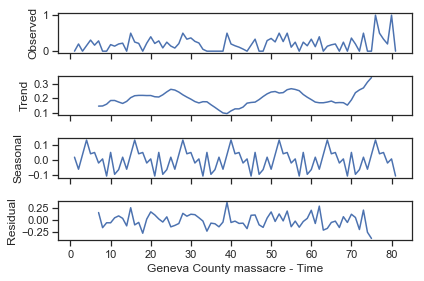

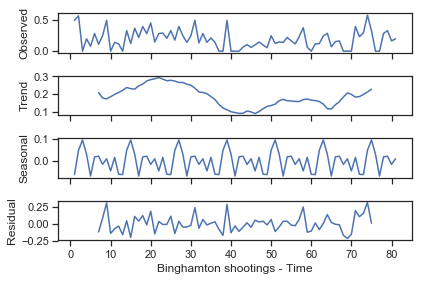

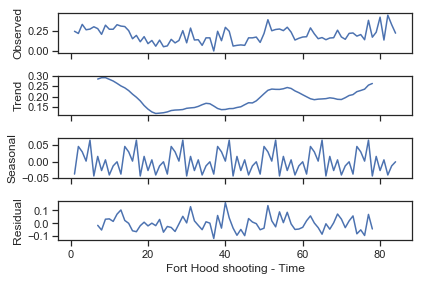

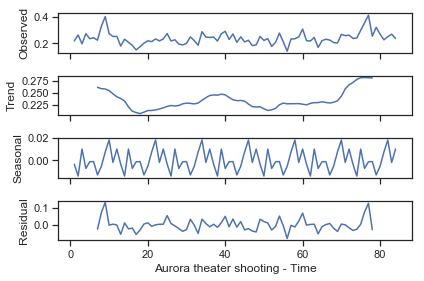

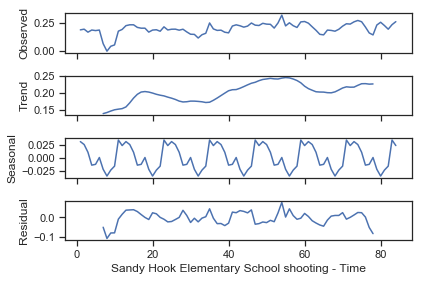

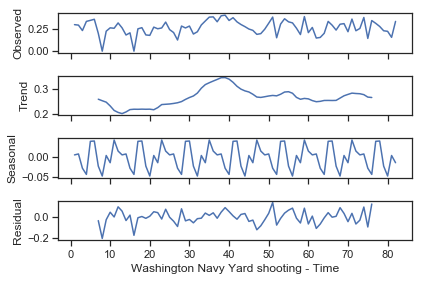

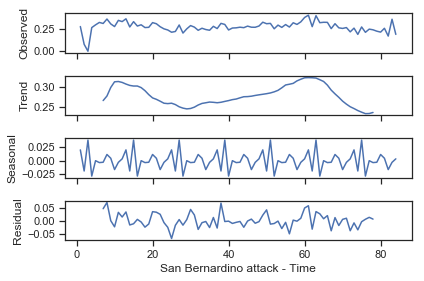

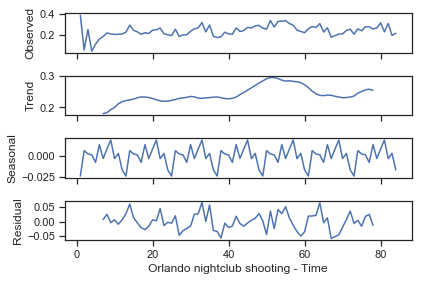

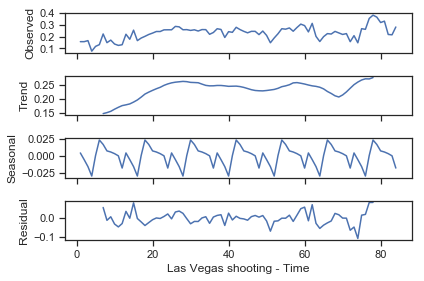

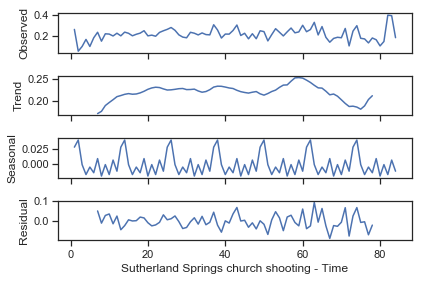

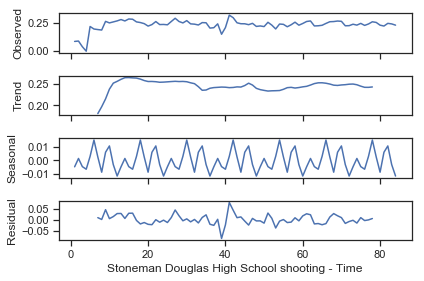

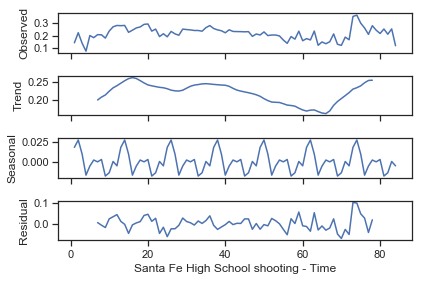

In [19]:
%matplotlib inline
for i in list(range(0, len(events))):
    series = scores_df[(scores_df.event == events[i])]
    series2 = series['score']
    series2.index = series['time_bin']
    result = seasonal_decompose(series2, model='additive', freq=12)
    result.plot()
    pyplot.xlabel(events[i] + " - Time")
    pyplot.show()

